the goal of this notebook is to be able to:

- take a timeseries that contains gaps
- train a GPFA Learner using the available data
- impute the gap, by using the predictions of the learner
- to improve the imputation by conditioning the distribution on the other observation at the same time stamp

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#| hide
#| default_exp imputation

In [3]:
#| export
from gpfa_imputation.learner import *

import torch

import pandas as pd
import numpy as np
from fastcore.foundation import patch

import matplotlib.pyplot as plt
import altair as alt

In [4]:
torch.manual_seed(277); # set seed for reproducibility of examples

## Fake data 

generate some fake data in order to test the imputation

What is does is:
- take a function to generate the "true" latent
- use some random coefficient to generate all the N features
- add some random noise

In [5]:
#| exports
class GPFADataGenerator:
    def __init__(self,
                    n_features: int,
                    n_obs: int,
                    latent_func = lambda x: torch.sin(3*x), # Functions used to generate the true latent
                    noise_std = .2,
                    Lambda = None
                ):
        
        self.n_features, self.n_obs = n_features, n_obs
        self.time = torch.arange(0, self.n_obs, dtype=torch.float)
        
        self.latent = latent_func(self.time)
        
        self.Lambda = torch.tensor(Lambda).reshape(n_features, 1) if Lambda is not None else torch.rand(n_features, 1)
        
        self.exact_X = (self.Lambda * self.latent).T
        
        self.X =  self.exact_X + torch.normal(0., noise_std, size = (n_obs, n_features)) 
        
        self.data = pd.DataFrame(self.X.numpy(), columns = [f"x{i}" for i in range(self.n_features)]) 
        

In [6]:
#| exports
class GPFADataTest:
    def __init__(self, data: pd.DataFrame):
        " Init with provided dataset"
        self.data = data
        self.n_features, self.n_obs = data.shape[1], data.shape[0]
        self.time = torch.arange(0, self.n_obs, dtype=torch.float)
    @classmethod
    def generate(cls, *args, **kwargs):
        generator = GPFADataGenerator(*args, **kwargs)
        self = GPFADataTest(generator.data)
        self.generator = generator
        return self

In [7]:
fdg = GPFADataGenerator(3, 4)

In [8]:
fd_plot = pd.DataFrame(fdg.X.numpy(), columns = ["x1", "x2", "x3"])
fd_plot["latent"] = pd.Series(fdg.latent.numpy())

<AxesSubplot: >

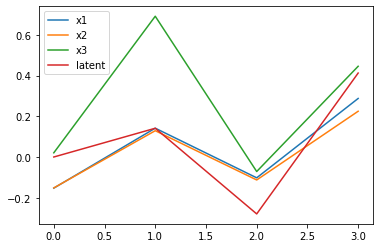

In [9]:
fd_plot.plot()

### Missing Data

add to the fake data class the ability to generate some missing data

In [10]:
#| exports
@patch()
def add_random_missing(self: GPFADataTest,
                prob_miss_row: float = .2,#  Probability an entire row is missing
                prob_miss_value: float = .1 # Probability a single observation is missing       
               ):
    """Make some row and same values randomly missing """
    # keep the original data
    self.data_complete = self.data.copy()
        
    self.is_miss_row = torch.rand(self.n_obs) <= prob_miss_row
    
    self.data[self.is_miss_row.numpy()] = np.nan
    
    self.is_miss_value = (torch.rand(self.n_obs * self.n_features) <= prob_miss_value).reshape(-1, self.n_features)
    
    self.data[self.is_miss_value.numpy()] = np.nan
    
    return self

In [11]:
fd = GPFADataTest.generate(3, 4)

In [12]:
fd.add_random_missing().data

,x0,x1,x2
0,-0.001938,-0.127557,NaN
1,NaN,NaN,NaN
2,0.137062,0.151774,-0.092625
3,NaN,NaN,NaN


In [13]:
GPFADataTest.generate(2, 10).add_random_missing(prob_miss_value = .7, prob_miss_row=.0).data

,x0,x1
0,-0.203655,-0.117674
1,NaN,NaN
2,NaN,-0.111792
3,NaN,NaN
4,NaN,NaN
5,NaN,0.112875
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,0.409263


### Save as DataFrame

In [14]:
#| exports
@patch
def tidy_df(self: GPFADataTest,
          complete = False, # full dataset (False) or the one with missing data (True)
          is_missing = False # add flag whether value is missing
         ):
    
    df = self.data if not complete else self.data_complete # no need to copy here because next lines does a copy anyway
    df = df.assign(time = self.time.numpy())
        
    df = df.melt("time")
    
    if is_missing: df = df.assign(is_missing = self.data.melt().value.isna()) #missing data is not from complete data
        
    return df

In [15]:
fd.tidy_df()

,time,variable,value
0,0.0,x0,-0.001938
1,1.0,x0,NaN
2,2.0,x0,0.137062
3,3.0,x0,NaN
4,0.0,x1,-0.127557
5,1.0,x1,NaN
6,2.0,x1,0.151774
7,3.0,x1,NaN
8,0.0,x2,NaN
9,1.0,x2,NaN


In [16]:
fd.tidy_df(complete=True)

,time,variable,value
0,0.0,x0,-0.001938
1,1.0,x0,0.021966
2,2.0,x0,0.137062
3,3.0,x0,0.031551
4,0.0,x1,-0.127557
5,1.0,x1,0.295225
6,2.0,x1,0.151774
7,3.0,x1,0.116207
8,0.0,x2,0.139568
9,1.0,x2,0.029323


In [17]:
fd.tidy_df(complete=False, is_missing=True)

,time,variable,value,is_missing
0,0.0,x0,-0.001938,False
1,1.0,x0,NaN,True
2,2.0,x0,0.137062,False
3,3.0,x0,NaN,True
4,0.0,x1,-0.127557,False
5,1.0,x1,NaN,True
6,2.0,x1,0.151774,False
7,3.0,x1,NaN,True
8,0.0,x2,NaN,True
9,1.0,x2,NaN,True


The export as a dataframe is working correctly with the missing data

In [18]:
fd_df = fd.tidy_df()

In [19]:
alt.Chart(fd_df).mark_line(point=True).encode(
    x = "time",
    y = "value",
    color = "variable"
)

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [20]:
fd.data

,x0,x1,x2
0,-0.001938,-0.127557,NaN
1,NaN,NaN,NaN
2,0.137062,0.151774,-0.092625
3,NaN,NaN,NaN


## GPFA Imputation

This is the core class that does the imputation using a GPFA

The inputs is:

- a dataframe containing the observed data, where the row with missing data have been removed
- a vector of times where the data is missing

it returns:

- a complete dataframe with the prediction of the model

The goal is that `GPFAImputation` takes as imput a dataframe containing missing values and then it imputes them using GPFALearner.
Therefore it needs to divide the dataframe in 3 sections:

- training data (rows with no NAs)
- times to be imputed (rows with some NAs)
- observations (variables in the pred rows that are not missing) for conditional predictions

In [21]:
t_df = pd.DataFrame([
    [1., 3., 4.],
    [2., 6., np.nan],
    [np.nan, np.nan, np.nan],
    [np.nan, 8., np.nan],
    [3., 4., 5.]
]
)

In [22]:
train_idx = ~t_df.isna().any(1)

/tmp/ipykernel_48155/3664883938.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  train_idx = ~t_df.isna().any(1)


In [23]:
t_df[train_idx]

,0,1,2
0,1.0,3.0,4.0
4,3.0,4.0,5.0


In [24]:
pred_data = t_df[~train_idx].to_numpy() 

In [25]:
pred_data

array([[ 2.,  6., nan],
       [nan, nan, nan],
       [nan,  8., nan]])

In [26]:
idx_cond = ~t_df[~train_idx].isna()

In [27]:
idx_cond

,0,1,2
1,True,True,False
2,False,False,False
3,False,True,False


In [28]:
idx_cond = idx_cond.to_numpy().flatten() # learner needs a 1D index

pred_data.flatten()[idx_cond]

train_idx = t_df.isna().any(axis=1)

torch.tensor(~t_df[~train_idx].isna().to_numpy().flatten())

tensor([True, True, True, True, True, True])

Implement this into a function

In [29]:
#| exports
class GPFAImputation:
    def __init__(
        self,
        data: pd.DataFrame , #observed data with missing data as NA
    ):
        self.data = data
        self.T = torch.arange(0, len(data), dtype=torch.float32) # time is encoded with a increase of 1
        
        # Training data
        self.train_idx = ~self.data.isna().any(axis=1)
        self.train_data = torch.tensor(self.data[self.train_idx].to_numpy().astype(np.float32))
        self.train_T = self.T[self.train_idx]
        
        self.learner = GPFALearner(X = self.train_data, T = self.train_T)

        # Prediction data
        self.pred_T = self.T[~self.train_idx]
        self.cond_idx = torch.tensor(~self.data[~self.train_idx].isna().to_numpy().flatten()) # conditional obsevations
        self.cond_obs = torch.tensor(self.data[~self.train_idx].to_numpy().astype(np.float32).flatten()[self.cond_idx])
        
        
    def impute(self,
               add_time = True, # add column with time?
               tidy = True # tidy data?
               ):
        self.learner.train()
        self.pred = self.learner.predict(self.pred_T, obs = self.cond_obs, idx = self.cond_idx)
        
        if tidy: return self._impute_tidy(add_time)
        else: return self._impute_wide(add_time)
        
        
    def _impute_wide(self, add_time):
        """ Impute in wide format"""
        
        imp_data = self.data.copy()
        for col_idx, col_name in enumerate(imp_data.columns):
            imp_data.loc[~self.train_idx, col_name] = self.pred.mean[:, col_idx].numpy()
            imp_data.loc[~self.train_idx, col_name + "_std"] = self.pred.std[:, col_idx].numpy()
        
        idx_vars = []
        if add_time:
            imp_data["time"] = self.T
            idx_vars.append("time")
        
        return imp_data 
    
    def _impute_tidy(self, add_time):
        """ transform the pred output into a tidy dataframe suitable for plotting"""
        feature_names = self.data.columns

        pred_mean = pd.DataFrame(self.pred.mean, columns = feature_names).assign(time = self.pred_T).melt("time", value_name="mean")
        pred_std = pd.DataFrame(self.pred.std, columns = feature_names).assign(time = self.pred_T).melt("time", value_name="std")
        
        pred = pd.merge(pred_mean, pred_std, on=['time', 'variable'])  
        
        train_data = self.data[self.train_idx].assign(time = self.train_T).melt("time", value_name = "mean")
               
        imp_data = pd.concat((train_data, pred))
        
        return imp_data
    

In [30]:
fd = GPFADataTest.generate(2, 10, Lambda=[1,2.]).add_random_missing()

In [31]:
fd.data

,x0,x1
0,0.166732,-0.148720
1,NaN,NaN
2,-0.010286,NaN
3,0.188540,0.631728
4,-0.436093,-1.140182
5,0.642759,1.255195
6,-0.746650,-1.563779
7,1.176085,2.160122
8,-0.925860,-1.881698
9,NaN,NaN


In [32]:
imp = GPFAImputation(fd.data)

In [33]:
pred = imp.impute()
pred

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: operator() profile_node %840 : int[] = prim::profile_ivalue(%838)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  Variable._execution_engine.run_backward(  # Calls into the C++ eng

,time,variable,mean,std
0,0.0,x0,0.166732,NaN
1,3.0,x0,0.188540,NaN
2,4.0,x0,-0.436093,NaN
3,5.0,x0,0.642759,NaN
4,6.0,x0,-0.746650,NaN
5,7.0,x0,1.176085,NaN
6,8.0,x0,-0.925860,NaN
7,0.0,x1,-0.148720,NaN
8,3.0,x1,0.631728,NaN
9,4.0,x1,-1.140182,NaN


In [34]:
imp.impute(tidy=False)

,x0,x1,x0_std,x1_std,time
0,0.166732,-0.148720,NaN,NaN,0.0
1,0.009359,-0.098191,0.700994,1.405001,1.0
2,-0.010286,-0.137108,0.000000,0.213153,2.0
3,0.188540,0.631728,NaN,NaN,3.0
4,-0.436093,-1.140182,NaN,NaN,4.0
5,0.642759,1.255195,NaN,NaN,5.0
6,-0.746650,-1.563779,NaN,NaN,6.0
7,1.176085,2.160122,NaN,NaN,7.0
8,-0.925860,-1.881698,NaN,NaN,8.0
9,0.009359,-0.098191,0.700994,1.405001,9.0


### Prediction plot

In [35]:
#| exports
@patch()
def plot_pred(
    self: GPFAImputation,
    complete = None # Optional true data to be plotted agaist predictions
):
    
    imp = self._impute_tidy(add_time=True) if hasattr(self, "pred") else self.impute(tidy=True, add_time=True)
    
    error = alt.Chart(imp).mark_errorband().encode(
        x = "time",    
        y = alt.Y("err_low:Q", title=""),
        y2 = "err_high:Q",
        color="variable"
    ).transform_calculate(
        err_low = "datum.mean - 2 * datum.std",
        err_high = "datum.mean + 2 * datum.std"
    )

    pred = alt.Chart(imp).mark_line().encode(
        x = "time",    
        y = alt.Y("mean:Q", title="value variable"),
        color="variable"
    )

    plot = error + pred
    
    if complete is not None:
        
        truth_plt = alt.Chart(complete).mark_point().encode(
            x = "time",
            y = alt.Y("value", title="value variable"),
            color="variable",
            shape = "is_missing"
        )
        
        plot = plot + truth_plt
    
    
    return plot

In [36]:
imp.plot_pred(complete = fd.tidy_df(complete=True, is_missing=True))

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

In [37]:
imp.plot_pred()

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

The code is running correctly and as expected around the missing data point the error is band is wider

### Repr

add `__repr__` and `__str__` to imputation objects

In [43]:
#| exports
@patch
def __repr__(self: GPFAImputation):
    return f"""GPFA Imputation:
    N obs: {self.data.shape[0]}
    N features {self.data.shape[1]} ({', '.join(self.data.columns)})
    N missing observations {self.cond_idx.sum()}"""

@patch
def __str__(self: GPFAImputation):
    return self.__repr__()

In [39]:
imp

GPFA Imputation:
    N obs: 10
    n_features 2 (x0, x1)
    n missing observations $1

In [40]:
str(imp)

'GPFA Imputation:\n    N obs: 10\n    n_features 2 (x0, x1)\n    n missing observations $1'

In [45]:
#| hide
from nbdev import nbdev_export
nbdev_export()